In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import geeksw.plotting.cmsplot as plt
from libwwz import wwz_plotting
import uproot_methods

In [4]:
import libwwz
libwwz.config.year = 2018

In [5]:
import json
import numba
from numba.typed import Dict
from numba import types
import numpy as np

class LumiMask(object):
    """Holds a luminosity mask index, and provides vectorized lookup
    Parameters
    ----------
        jsonfile : str
            Path the the 'golden json' file or other valid lumiSection database in json format.
    This class parses a CMS lumi json into an efficient valid lumiSection lookup table
    """
    def __init__(self, jsonfile):
        with open(jsonfile) as fin:
            goldenjson = json.load(fin)

        self._masks = Dict.empty(
            key_type=types.uint32,
            value_type=types.uint32[:]
        )

        for run, lumilist in goldenjson.items():
            mask = np.array(lumilist, dtype=np.uint32).flatten()
            mask[::2] -= 1
            self._masks[np.uint32(run)] = mask

    def __call__(self, runs, lumis):
        """Check if run and lumi are valid
        Parameters
        ----------
            runs : numpy.ndarray
                Vectorized list of run numbers
            lumis : numpy.ndarray
                Vectorized list of lumiSection numbers
        Returns
        -------
            mask_out : numpy.ndarray
                An array of dtype `bool` where valid (run, lumi) tuples
                will have their corresponding entry set ``True``.
        """
        mask_out = np.zeros(dtype='bool', shape=runs.shape)
        LumiMask._apply_run_lumi_mask(self._masks, runs, lumis, mask_out)
        return mask_out

    @staticmethod
    def _apply_run_lumi_mask(masks, runs, lumis, mask_out):
        LumiMask._apply_run_lumi_mask_kernel(masks, runs, lumis, mask_out)

    # This could be run in parallel, but windows does not support it
    @staticmethod
    @numba.njit(parallel=False, fastmath=True)
    def _apply_run_lumi_mask_kernel(masks, runs, lumis, mask_out):
        for iev in numba.prange(len(runs)):
            run = np.uint32(runs[iev])
            lumi = np.uint32(lumis[iev])

            if run in masks:
                lumimask = masks[run]
                ind = np.searchsorted(lumimask, lumi)
                if np.mod(ind, 2) == 1:
                    mask_out[iev] = 1

In [6]:
lumi_masks = {
    2016 : LumiMask("Cert_271036-284044_13TeV_23Sep2016ReReco_Collisions16_JSON.txt"),
    2017 : LumiMask("Cert_294927-306462_13TeV_PromptReco_Collisions17_JSON.txt"),
    2018 : LumiMask("Cert_314472-325175_13TeV_17SeptEarlyReReco2018ABC_PromptEraD_Collisions18_JSON.txt"),
}

In [7]:
import uproot
import os
import numpy as np
import pandas as pd

In [8]:
from geeksw.utils.core import concatenate
from geeksw.utils.data_loader_tools import make_data_loader, TreeWrapper, list_root_files_recursively

In [9]:
def analyze_dataset(year, short_name, override_path=None, scale=1.):
    df_full = libwwz.utils.load_four_lepton_skim(year, short_name)
    
    return libwwz.four_lepton_analysis.four_lepton_analysis(df_full, use_z_id_as_w_id=False)

In [10]:
samples_info = {"wwz" : [(2016, "WWZ_incl"), # skim validated for all years
                         (2017, "WWZ_4l"),
                         (2018, "WWZ_4l")],
                "ttz" : [(2016, "TTZnlo_ext2"), # skim validated for all years
                         (2017, "TTZnlo"),
                         (2018, "TTZnlo"),
                        (2016, "TTZLOW"),
                         (2017, "TTZLOW"),
                         (2018, "TTZLOW")],
                "zz" : [(2016, "ZZ"), (2017, "ZZ"), (2018, "ZZ_ext1")],
               "wz" : [(2016, "WZ"), (2017, "WZ"), (2018, "WZ")],
               "twz" : [(2016, "TWZ"), (2017, "TWZ"), (2018, "TWZ")],
               "tt" : [
                   (2016, "TTDL"),
                   (2016, "TTSLtop"),
                   (2016, "TTSLtopbar"),
                   (2017, "TTDL"),
                   (2017, "TTSL"),
                   (2018, "TTDL"),
                   (2018, "TTSL"),
               ],
               "othernoh" : [(2016, "DY_high"), (2017, "DY_high"), (2018, "DY_high")]}

In [11]:
def analyze_data():
    dfs = []
    
    paths = [
            "/scratch/skims/data/2016/data_Run2016Bv1_ee/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016Bv2_ee/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016C_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016D_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016E_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016F_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016G_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016H_ee/four_lepton_skim",
        
            "/scratch/skims/data/2016/data_Run2016Bv1_em/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016Bv2_em/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016C_em/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016D_em/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016E_em/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016F_em/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016G_em/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016H_em/four_lepton_skim",
        
            "/scratch/skims/data/2016/data_Run2016Bv1_mm/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016Bv2_mm/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016C_mm/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016D_mm/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016E_mm/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016F_mm/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016G_mm/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016H_mm/four_lepton_skim",

             "/scratch/skims/data/2017/data_Run2017B_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017C_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017D_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017E_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017F_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017B_em/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017C_em/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017D_em/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017E_em/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017F_em/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017B_mm/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017C_mm/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017D_mm/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017E_mm/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017F_mm/four_lepton_skim",

            "/scratch/skims/data/2018/EGamma_2018A/four_lepton_skim",
            "/scratch/skims/data/2018/EGamma_2018B/four_lepton_skim",
            "/scratch/skims/data/2018/EGamma_2018C/four_lepton_skim",
            "/scratch/skims/data/2018/EGamma_2018D/four_lepton_skim",
            "/scratch/skims/data/2018/DoubleMuon_2018A/four_lepton_skim",
        "/scratch/skims/data/2018/DoubleMuon_2018B/four_lepton_skim",
        "/scratch/skims/data/2018/DoubleMuon_2018C/four_lepton_skim",
        "/scratch/skims/data/2018/DoubleMuon_2018D/four_lepton_skim",
            "/scratch/skims/data/2018/MuonEG_2018A/four_lepton_skim",
            "/scratch/skims/data/2018/MuonEG_2018B/four_lepton_skim",
            "/scratch/skims/data/2018/MuonEG_2018C/four_lepton_skim",
            "/scratch/skims/data/2018/MuonEG_2018D/four_lepton_skim",
        
            ]
    for path in paths:
        df_full = libwwz.utils.load_four_lepton_skim(None, None, override_path=path)
        dfs.append(libwwz.four_lepton_analysis.four_lepton_analysis(df_full, use_z_id_as_w_id=False))
        
        if "2016" in path:
            mask = lumi_masks[2016]
        if "2017" in path:
            mask = lumi_masks[2017]
        if "2018" in path:
            mask = lumi_masks[2018]
            
        dfs[-1] = dfs[-1][mask(dfs[-1].run.values, dfs[-1].lumi.values)]
        
    df = pd.concat(dfs, ignore_index=True, axis=0)
    
    return df.drop_duplicates("evt")

In [12]:
def analyze_sample(sample_name):
    dfs = []
    for tup in samples_info[sample_name]:
        scale = 1.
        if len(tup) == 2:
            year, short_name = tup
        else:
            year, short_name, scale = tup
        dfs.append(analyze_dataset(year, short_name, scale=scale))
    return pd.concat(dfs, ignore_index=True)

In [27]:
samples = {}

In [28]:
samples["wwz"] = analyze_sample("wwz")

In [29]:
samples["data"] = analyze_data()

In [30]:
samples["ttz"] = analyze_sample("ttz")

In [31]:
samples["tt"] = analyze_sample("tt")

In [32]:
samples["zz"] = analyze_sample("zz")

In [33]:
samples["wz"] = analyze_sample("wz")
samples["twz"] = analyze_sample("twz")

In [34]:
samples["othernoh"] = analyze_sample("othernoh")

In [35]:
jagged_lepton_variable = libwwz.four_lepton_analysis.jagged_lepton_variable

for sample_name in samples:
    lep_pt = jagged_lepton_variable(samples[sample_name], "pt")
    samples[sample_name]["lep_min_pt"] = lep_pt.min()
    samples[sample_name]["lep_max_pt"] = lep_pt.max()
    samples[sample_name]["lep_min_iso"] = np.log(jagged_lepton_variable(samples[sample_name], "pfRelIso03_all_wLep").min())
    samples[sample_name]["lep_max_iso"] = np.log(jagged_lepton_variable(samples[sample_name], "pfRelIso03_all_wLep").max())
    
    samples[sample_name]["ZCand_mass_1"] = samples[sample_name]["ZCand_mass_1"].fillna(0.0)
    
    samples[sample_name]["sT"] = samples[sample_name]["veto_lepton_pt_sum"] + samples[sample_name]["MET_pt"]

/home/llr/cms/rembser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/llr/cms/rembser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [43]:

def clip(a, a_max=800):
    return np.clip(a, a_min=None, a_max=a_max)

bins = np.linspace(0, 800, 16)
#bins = np.linspace(0, 300, 46)

for sample_name in ["wwz", "ttz", "zz", "wz"]:
    print(sample_name)
    print(samples[sample_name].groupby("category")["weight"].sum())
    print()
    df_q = samples[sample_name].query("category == 'EMu'")
    #print(sample_name, df_q["weight"].sum())

    #plt.hist(clip(df_q["ZCand_mass_1"]),
    ##plt.hist(clip(df_q["VetoLepton_pt_2"]),
    ##plt.hist(clip(df_q["veto_lepton_pt_min"]),
    #         bins=bins,
    #         weights=np.clip(df_q["weight"], a_min=None, a_max=None),
    #         histtype="step",
    #         label=sample_name)
    
#plt.legend(loc="upper right")

#plt.yscale('log', nonposy='clip')
#plt.show()

wwz
category
BTagEMu            1.437243
EMu                8.572844
OffZ               9.092642
OnZ                1.198208
uncategorized    156.011852
Name: weight, dtype: float64

ttz
category
BTagEMu           11.479790
EMu                1.136398
OffZ              12.119847
OnZ                1.800374
uncategorized    293.885274
Name: weight, dtype: float64

zz
category
BTagEMu             1.044761
EMu                 8.796092
OffZ              159.673769
OnZ               379.072233
uncategorized    4205.856822
Name: weight, dtype: float64

wz
category
BTagEMu            0.662188
EMu                4.419024
OffZ               5.853382
OnZ                0.894913
uncategorized    117.611534
Name: weight, dtype: float32



/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:193: RuntimeWarning: invalid value encountered in true_divide
  y = data_events / baseline_events
/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:194: RuntimeWarning: invalid value encountered in true_divide
  yerr = data_errors2 ** 0.5 / baseline_events
/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:207: RuntimeWarning: invalid value encountered in true_divide
  to_y((baseline_events - baseline_errors) / baseline_events),
/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:208: RuntimeWarning: invalid value encountered in true_divide
  to_y((baseline_events + baseline_errors) / baseline_events),
No handles with labels found to put in legend.


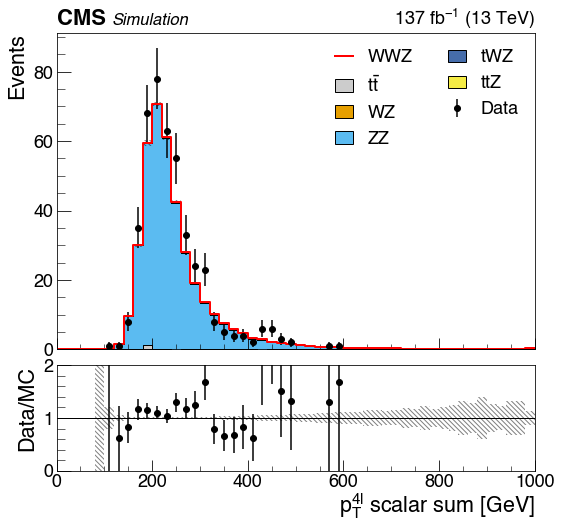

In [55]:
#query = "category == 'EMu' and m_ll > 135"# and MET_pt < 50"
query = "category == 'OnZ'"# and MET_pt < 50"
#query = "m_ll > 100"
#query = "not category == 'OnZ'"

bins = np.linspace(0, 1000, 51)
#bins = np.linspace(0, 250, 4)

wwz_plotting.wvz_hist(
    samples,
    "sT",
    #"m_ll",
    bins,
    #query="is_ChannelEMu",
    main_background="ttz",
    plot_data=True,
    data_scale=None,
    ratio_plot=True,
    xlabel=r"$p_T^{4l}$ scalar sum [GeV]",
    query=query,
    stack_signal_on_background=True,
    #ylim=(0,7.4),
    #log_scale=True,
)
#plt.show()
df_q = samples["wwz"].query(query)
#h = np.histogram(clip(df_q["sT"], a_max=bins[-1]), bins, weights=df_q["weight"])[0] * h_eft_scale
#plt.step(bins[1:], h, label=r"WWZ $f_{T0} = 1$ TeV${}^{-4}$")
plt.legend(loc="upper left")
plt.savefig("eft_plot.pdf")
plt.show()
plt.close()
#plt.ylim(0, 11)

In [89]:
h_eft_scale

NameError: name 'h_eft_scale' is not defined

In [ ]:
#df_wz = analyze_dataset(2018, "WZ")

In [ ]:
df_eft = analyze_dataset(None, None, override_path="/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/skims/2018_WWZ_dim8_four_lepton_skim")

In [ ]:
def get_weigth_scales_for_ft0(df, ft0_value):
    
    x = np.array([-10, -5.0, 0, 5.0, 10])
    xx = np.linspace(-10, 10, 200)
    weights = np.zeros(len(df))
    for i, y in enumerate(df[["EFT_FT0_m10", "EFT_FT0_m5", "EFT_SM", "EFT_FT0_5", "EFT_FT0_10"]].values):
        p = np.polyfit(x, y, 2)
        weights[i] = np.polyval(p, [ft0_value])
    return weights

In [ ]:
df_eft["sT"] = df_eft["veto_lepton_pt_sum"] + df_eft["MET_pt"]
df_eft_q = df_eft.query(query)

In [ ]:
plt.hist(df_eft_q["sT"], bins=bins);

In [228]:
scale_eft = get_weigth_scales_for_ft0(df_eft_q, 1.)

In [229]:
h_sm = np.histogram(clip(df_eft_q["sT"], a_max=bins[-1]), bins, weights=df_eft_q["genWeight"])[0]
h_eft = np.histogram(clip(df_eft_q["sT"], a_max=bins[-1]), bins, weights=df_eft_q["genWeight"] * scale_eft)[0]
h_eft_scale = h_eft / h_sm

/home/llr/cms/rembser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [230]:
def get_n_high_mass_events(ft0_value):
    mass_cut = 1200.
    query = f"category == 'EMu' and veto_lepton_pt_sum > {mass_cut}"
    #query = f"veto_lepton_pt_sum > {mass_cut}"
    if ft0_value == 0.0:
        return df_wwz_4l.query(query)["weight"].sum()
    
    df_q = df.query(query)
    weights = get_weigth_scales_for_ft0(df_q, ft0_value)
    return np.sum(weights * df_q["weight"])

In [ ]:
def nll_term(s, b, n):
    return (s + b) - n * np.log(s + b)

In [ ]:
ft0_vals = np.linspace(-5, 5, 50)
n_events = np.array(list(map(get_n_high_mass_events, ft0_vals)))
nll = np.array(list(map(lambda n : nll_term(0, get_n_high_mass_events(0.0), n), n_events)))

In [ ]:
plt.plot(ft0_vals, nll)

In [ ]:
df["EFT_FT0_0p2"] = get_weigths_for_ft0(df, 0.2)

In [90]:
import awkward

In [91]:
def jagged_pair_masses(df):
    content = df[
        [
            "VetoLeptonPair_mass_01",
            "VetoLeptonPair_mass_02",
            "VetoLeptonPair_mass_03",
            "VetoLeptonPair_mass_12",
            "VetoLeptonPair_mass_13",
            "VetoLeptonPair_mass_23",
        ]
    ].values.flatten()

    return awkward.JaggedArray.fromcounts(6 + np.zeros(len(df), dtype=np.int), content)

In [94]:
jagged_pair_masses(samples["data"])

<JaggedArray [[57.78742156760853 93.98619351153155 89.989714126135 83.5981694059316 71.78007070746519 27.887991810728256] [188.36628981707972 98.37212236230381 69.432742447723 117.49792739251417 87.97240471358678 46.58377405650752] [114.01133745354326 74.42071621807783 35.667216623079284 101.51600865958387 36.46201372742267 54.71326222912688] ... [69.6757841836272 60.88277093948502 11.195919401437529 15.946587379144981 30.21529792561081 26.718241714053335] [44.57130805027947 84.21411781023134 74.21799292901146 81.29365283231905 69.03624453222281 30.840726559208473] [60.05178056122186 74.84367192069962 46.3410399128571 136.69181968103155 67.47795057968695 23.428901773183927]] at 0x7fca84729cc0>

In [66]:
from geeksw.utils.array_utils import unpack_pair_values, awksel

In [23]:
a = unpack_pair_values(samples["data"],
                       column_getter=lambda i, j : f"VetoLeptonPair_mass_{i}{j}",
                       diagonal=np.nan,
                       jagged=False)

In [114]:
b = unpack_pair_values(samples["data"],
                       column_getter=lambda i, j : f"VetoLeptonPair_mass_{i}{j}",
                       diagonal=np.nan,
                       jagged=True)

In [62]:
x = np.array([1,2,3])
y = np.array([2,1,1])

In [33]:
x[:,None]

array([[1],
       [2],
       [1]])

In [28]:
a[[0,1,3]][:,x,y]

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [150]:
b[:,0,1]

array([ 57.78742157, 188.36628982, 114.01133745, ...,  69.67578418,
        44.57130805,  60.05178056])

In [48]:
def foo(arr):
    import awkward
    return awkward.JaggedArray.fromcounts(np.ones(len(arr), dtype=np.int), arr)

In [49]:
foo(x)

<JaggedArray [[1] [2] [3]] at 0x7fce6c81da90>

In [65]:
b[[1,2,3]][foo(x)].flatten()[foo(y)].flatten()

array([117.49792739, 101.51600866,  90.21829102])

In [64]:
a[1,2,1]

117.49792739251417

In [69]:
awksel(b[[1,2,3]], x, y)

array([117.49792739, 101.51600866,  90.21829102])

In [112]:
b.content = b.content.flatten()

In [115]:
b

<JaggedArray [[[nan 57.78742156760853 93.98619351153155 89.989714126135] [57.78742156760853 nan 83.5981694059316 71.78007070746519] [93.98619351153155 83.5981694059316 nan 27.887991810728256] [89.989714126135 71.78007070746519 27.887991810728256 nan]] [[nan 188.36628981707972 98.37212236230381 69.432742447723] [188.36628981707972 nan 117.49792739251417 87.97240471358678] [98.37212236230381 117.49792739251417 nan 46.58377405650752] [69.432742447723 87.97240471358678 46.58377405650752 nan]] [[nan 114.01133745354326 74.42071621807783 35.667216623079284] [114.01133745354326 nan 101.51600865958387 36.46201372742267] [74.42071621807783 101.51600865958387 nan 54.71326222912688] [35.667216623079284 36.46201372742267 54.71326222912688 nan]] ... [[nan 69.6757841836272 60.88277093948502 11.195919401437529] [69.6757841836272 nan 15.946587379144981 30.21529792561081] [60.88277093948502 15.946587379144981 nan 26.718241714053335] [11.195919401437529 30.21529792561081 26.718241714053335 nan]] [[nan 44